In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from datetime  import datetime
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE 
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

Check the data

In [3]:
df=pd.read_csv("../data/training_variants/training_variants")
print("The number of data points",df.shape[0])
print("The number of features",df.shape[1])
print("The features are :",df.columns.values)
df.head()

The number of data points 3321
The number of features 4
The features are : ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
df['Class'].nunique()

9

In [5]:
df['Variation'].nunique()

2996

There are 9 unique categories of output class
Gene - Location of the mutation
Variation - Type of variation

In [6]:
data_text =pd.read_csv("../data/training_text/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
stop_words = set(stopwords.words('english'))

def preprocess_text(full_text,index,column):
    if type(full_text) is not int:
        text = ""
        #replace special characters
        full_text=re.sub('[^\w+\n]', ' ', full_text)
        #replace multiple spaces with one space
        full_text=re.sub('[\s+]', ' ', full_text)
        # converting all the chars into lower-case.
        full_text = full_text.lower()
        
        for word in full_text.split():
            if word not in stop_words:
                text+=word+" "
        
        data_text[column][index]=text
                

In [8]:
start_time=datetime.now()
for index,row in data_text.iterrows():
    if type(row["TEXT"]) is str:
        preprocess_text(row["TEXT"],index,"TEXT")
    else:
        print(f"No text found at index {index}")

print(f"Time taken for the preprocessing - {datetime.now().second-start_time.second} seconds")

No text found at index 1109
No text found at index 1277
No text found at index 1407
No text found at index 1639
No text found at index 2755
Time taken for the preprocessing - -8 seconds


In [9]:
#Merge dataframes
result_data=pd.merge(df,data_text,on='ID',how='left')
result_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
result_data.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [11]:
result_data[result_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


There are some NAN text in the result dataframe so we will just fill with the text of Gene and Variation

In [12]:
result_data.loc[result_data['TEXT'].isnull(),'TEXT']=result_data['Gene']+' '+result_data['Variation']

In [13]:
result_data[result_data['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<AxesSubplot:xlabel='Class', ylabel='count'>

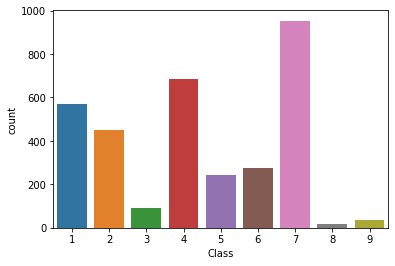

In [14]:
sns.countplot(data=result_data,x='Class')

The target class distribution is not uniform

In [15]:
y_true = result_data['Class'].values
result_data.Gene      = result_data.Gene.str.replace('\s+', '_')
result_data.Variation = result_data.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(result_data, y_true, stratify=y_true, test_size=0.2)

train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [16]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [17]:
train_class_distribution = train_df['Class'].value_counts().sort_index(ascending=False)
test_class_distribution = test_df['Class'].value_counts().sort_index(ascending=False)
cv_class_distribution = cv_df['Class'].value_counts().sort_index(ascending=False)

In [27]:
train_class_distribution

9     24
8     12
7    609
6    176
5    155
4    439
3     57
2    289
1    363
Name: Class, dtype: int64

Number of data points in class 3 : 609 ( 28.672 %)
Number of data points in class 6 : 439 ( 20.669 %)
Number of data points in class 9 : 363 ( 17.09 %)
Number of data points in class 8 : 289 ( 13.606 %)
Number of data points in class 4 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 7 : 57 ( 2.684 %)
Number of data points in class 1 : 24 ( 1.13 %)
Number of data points in class 2 : 12 ( 0.565 %)


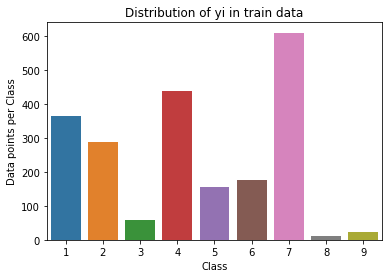

In [33]:
ax=sns.barplot(train_class_distribution.index,train_class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 3 : 191 ( 28.722 %)
Number of data points in class 6 : 137 ( 20.602 %)
Number of data points in class 9 : 114 ( 17.143 %)
Number of data points in class 8 : 91 ( 13.684 %)
Number of data points in class 4 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 7 : 18 ( 2.707 %)
Number of data points in class 1 : 7 ( 1.053 %)
Number of data points in class 2 : 4 ( 0.602 %)


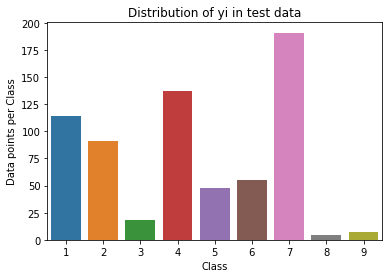

In [34]:
ax=sns.barplot(test_class_distribution.index,test_class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 3 : 153 ( 28.759 %)
Number of data points in class 6 : 110 ( 20.677 %)
Number of data points in class 9 : 91 ( 17.105 %)
Number of data points in class 8 : 72 ( 13.534 %)
Number of data points in class 4 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 7 : 14 ( 2.632 %)
Number of data points in class 1 : 6 ( 1.128 %)
Number of data points in class 2 : 3 ( 0.564 %)


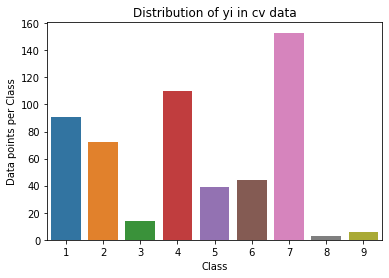

In [35]:
ax=sns.barplot(cv_class_distribution.index,cv_class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')